## Загрузим нужные библиотеки

In [2]:
import pandas as pd
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Импортируем данные

In [3]:
df = pd.read_csv("../train_dataset_train.csv")
sub = pd.read_csv("../test_dataset_test.csv")

4830
sample_solution.csv    train_dataset_train.csv	Поля_baseline.ipynb
test_dataset_test.csv  Иннополис.pdf


<AxesSubplot: >

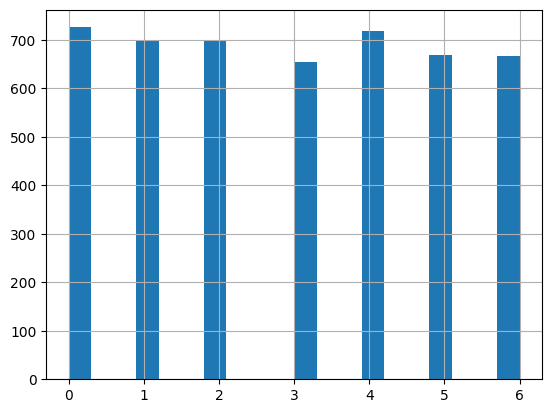

In [4]:
df['crop'].hist(bins=20)


# Изучим данные и заполним пропуски

In [5]:
df.head(3)

,id,area,.geo,2021-04-15,2021-04-16,2021-04-18,2021-04-19,2021-04-20,2021-04-22,2021-04-23,...,2021-07-31,2021-08-01,2021-08-07,2021-08-10,2021-08-11,2021-08-12,2021-08-13,2021-08-23,2021-08-27,crop
0,3536,20,"{""type"":""Polygon"",""coordinates"":[[[42.49107269...",0.187150,0.072846,0.262300,0.261778,0.063134,0.062981,0.000000,...,0.000000,0.754859,0.000000,0.030883,0.000000,0.658016,0.126832,0.034858,0.614770,3
1,3739,45,"{""type"":""Polygon"",""coordinates"":[[[50.25545110...",0.245285,0.332928,0.349133,0.287182,0.064671,0.097138,0.024539,...,0.089721,0.706226,0.184231,0.062582,0.618475,0.601685,0.174914,0.000000,0.179612,4
2,1294,28,"{""type"":""Polygon"",""coordinates"":[[[37.99698998...",0.006391,0.013679,0.000000,0.007055,0.000000,0.120804,0.112471,...,0.411168,0.000000,0.357296,0.045370,0.172080,0.000000,0.090607,0.000000,0.054127,2


In [6]:
# Добавляем еще один признак, означающий чило пропусков

value_cols = [col for col in df.columns if '2021' in col]

df['weight'] = 1 - np.mean(df[value_cols] == 0, axis=1)
sub['weight'] = 1- np.mean(sub[value_cols] == 0, axis=1)

# Заполняем пропуски

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

def knn_immput(df):

    value_cols = [col for col in df.columns if '2021' in col]

    for v in value_cols:
        zero_threshold = 0.00000
        drop_zero = lambda x: None if x <= zero_threshold else x 
        df[v] = df[v].apply(drop_zero)


    scaler = MinMaxScaler()
    ts = pd.DataFrame(scaler.fit_transform(df[value_cols]), columns = value_cols)
    ts.head()


    imputer = KNNImputer(n_neighbors=5)
    ts = pd.DataFrame(imputer.fit_transform(ts), columns = value_cols)

    for v in value_cols:
        df[v] = ts[v]


# knn_immput(df)
# knn_immput(sub)

# Ближ Средние
Заменяем пропуски ближайщими значениями

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

def mean_immput(df):

    value_cols = [col for col in df.columns if '2021' in col]

    for v in value_cols:
        zero_threshold = 0.00001
        drop_zero = lambda x: None if x <= zero_threshold else x 
        df[v] = df[v].apply(drop_zero)

    df[value_cols] = df[value_cols].interpolate(method ='linear', axis=1)


# mean_immput(df)
# mean_immput(sub)

# Добавяем полезные статистики

In [15]:
def simple_stats(df):
    value_cols = [col for col in df.columns if '2021' in col]
    df['ts_mean'] = df[value_cols].median(axis=1)
    df['ts_std'] = df[value_cols].std(axis=1)
    df['ts_sq'] = np.sum(df[value_cols]**2, axis=1)
    
simple_stats(df)
simple_stats(sub)

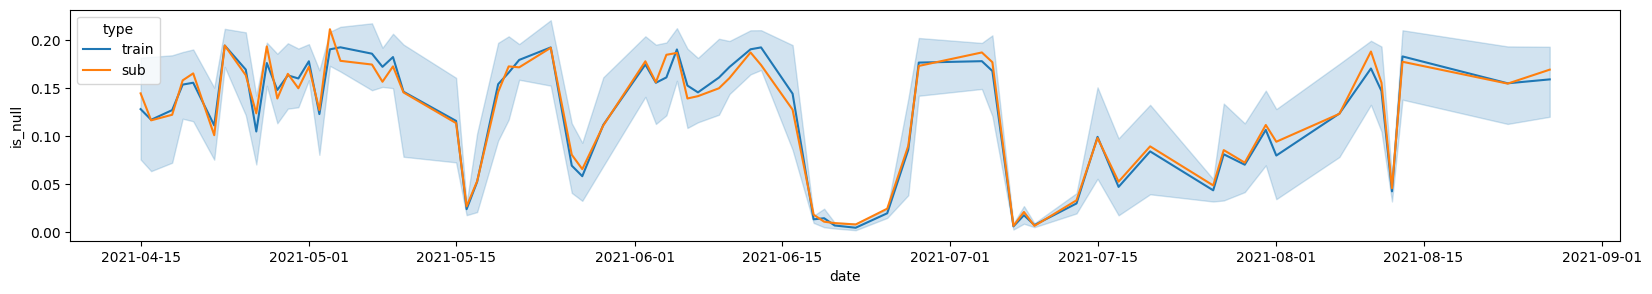

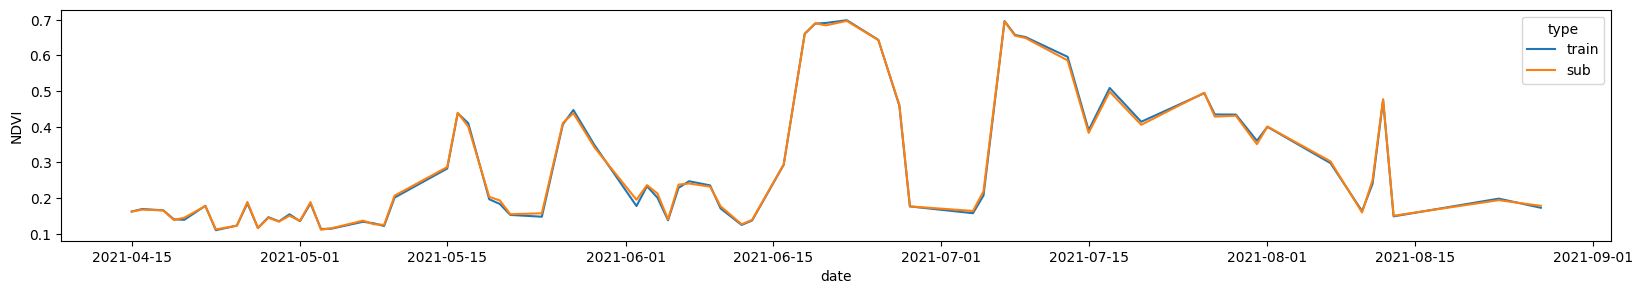

In [19]:
plt.figure(figsize = (20, 3))
train_melt_gr = train_melt.groupby(['date', 'crop'], as_index = False)['is_null'].mean()
sub_melt_gr = sub_melt.groupby('date', as_index = False)['is_null'].mean()

train_melt_gr['type'] = 'train'
sub_melt_gr['type'] = 'sub'

line_df = pd.concat([train_melt_gr, sub_melt_gr], axis=0, ignore_index=True)
sns.lineplot(data = line_df, x="date", y = 'is_null', hue = 'type'); 


plt.figure(figsize = (20, 3))
train_melt_gr = train_melt.groupby('date', as_index = False)['NDVI'].mean()
sub_melt_gr = sub_melt.groupby('date', as_index = False)['NDVI'].mean()

train_melt_gr['type'] = 'train'
sub_melt_gr['type'] = 'sub'
line_df = pd.concat([train_melt_gr, sub_melt_gr], axis=0, ignore_index=True)

sns.lineplot(data = line_df, x="date", y = 'NDVI', hue = 'type'); 

# NDVI не может быть меньше 0.07, хотя графики показывают обратное

In [22]:
from scipy.stats import f_oneway, ttest_ind, mannwhitneyu

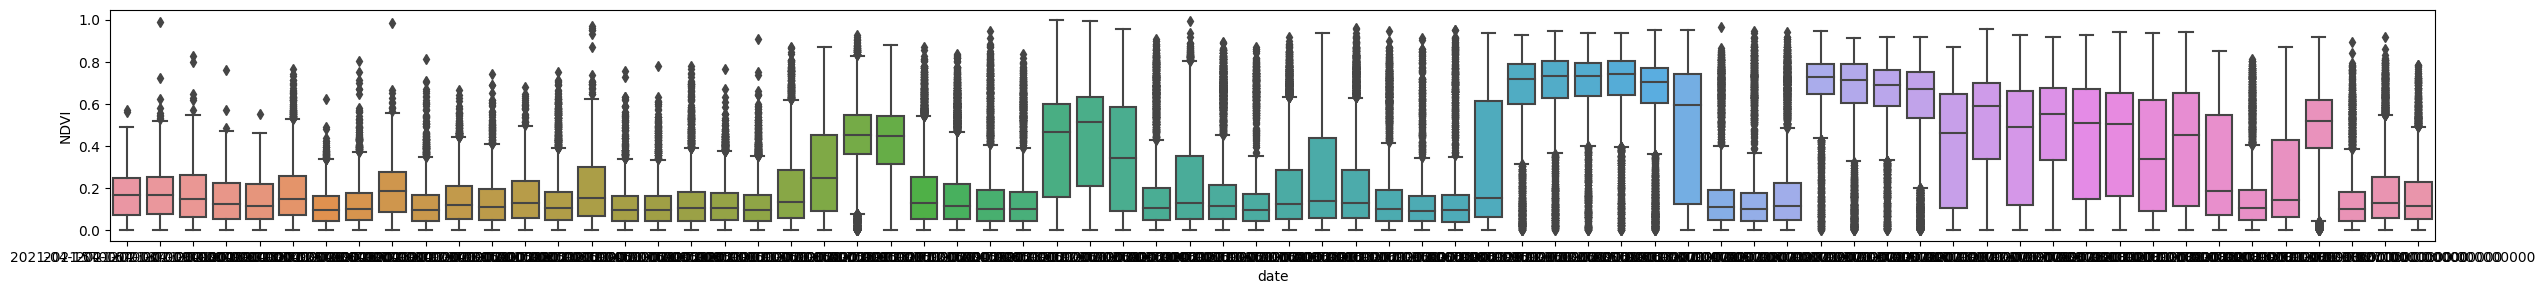

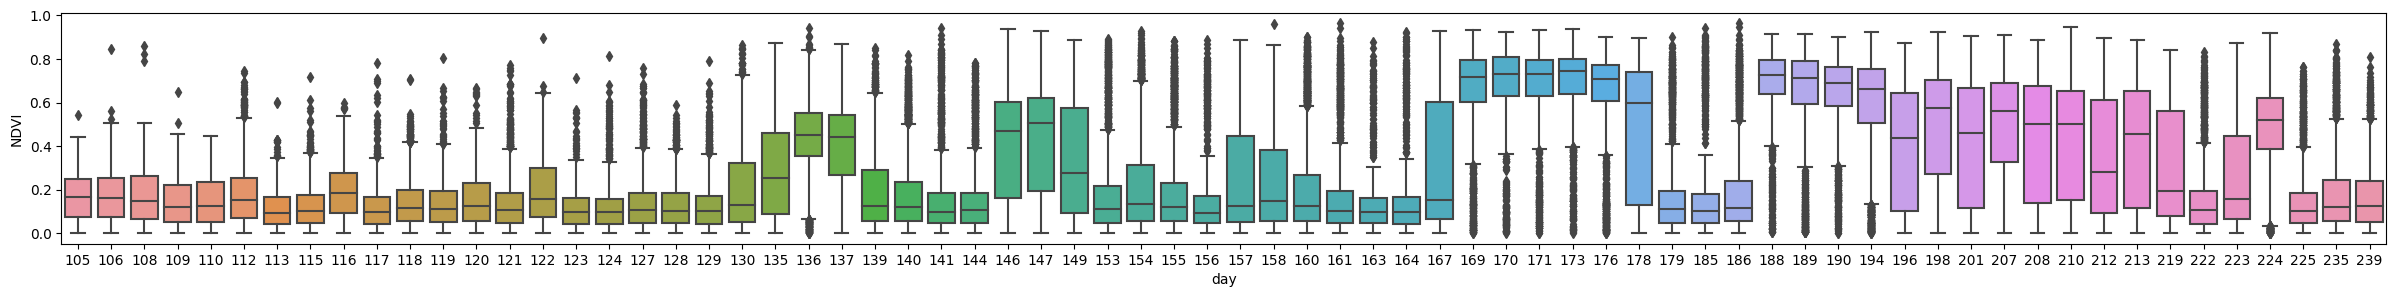

In [23]:
import matplotlib.ticker as ticker

plt.figure(figsize = (30, 3))
sns.boxplot(data = train_melt, x = 'date', y = 'NDVI')


plt.figure(figsize = (30, 3))
ax = sns.boxplot(data = sub_melt, x = 'day', y = 'NDVI')


# Генерируем еще признаки

In [30]:
# df[value_cols]
def shifts_fs(df):

    shift_value_cols = value_cols[1:] + value_cols[:1]
    pair_shift = dict(zip(shift_value_cols, value_cols))

    for i, (k, v) in enumerate(pair_shift.items()):
        # if i in [0, 9, 10, 14, 15, 16, 17, 23, 23, 28, 36, 38, 46, 47, 50, 51, 56]:
        df[f'shift_{i}'] = df[k] - df[v]


    shift_value_cols = value_cols[4:] + value_cols[:4]
    pair_shift = dict(zip(shift_value_cols, value_cols))

    for i, (k, v) in enumerate(pair_shift.items()):
        # if i in [11, 46, 47]:
        df[f'shift_4s_{i}'] = df[k] - df[v]


    shift_value_cols = value_cols[5:] + value_cols[:5]
    pair_shift = dict(zip(shift_value_cols, value_cols))

    for i, (k, v) in enumerate(pair_shift.items()):
        if i in [10, 15, 18, 24, 32, 35, 41, 45, 46, 48, 51]:
            df[f'shift_5s_{i}'] = df[k] - df[v]

    shift_value_cols = value_cols[8:] + value_cols[:8]
    pair_shift = dict(zip(shift_value_cols, value_cols))

    for i, (k, v) in enumerate(pair_shift.items()):
        if i in [7, 9, 15, 17, 32, 46, 51]:
            df[f'shift_step_8_{i}'] = df[k] - df[v]    

    shift_value_cols = value_cols[10:] + value_cols[:10]
    pair_shift = dict(zip(shift_value_cols, value_cols))

    for i, (k, v) in enumerate(pair_shift.items()):
        if i in [7, 28, 30, 34, 35, 46, 56]:
            df[f'shift_step_10_{i}'] = df[k] - df[v]


    for i, (k, v) in enumerate(pair_shift.items()):
        if i in [7, 28, 34, 35, 46, 51, 56]:
            print(v)
                
    
def rel_fs(df):

    shift_value_cols = value_cols[1:] + value_cols[:1]
    pair_shift = dict(zip(shift_value_cols, value_cols))

    for i, (k, v) in enumerate(pair_shift.items()):
        # if i in [0, 9, 10, 14, 15, 16, 17, 23, 23, 28, 36, 38, 46, 47, 50, 51, 56]:
        df[f'rel_{i}'] = df[k]/df[v]


    shift_value_cols = value_cols[2:] + value_cols[:2]
    pair_shift = dict(zip(shift_value_cols, value_cols))

    for i, (k, v) in enumerate(pair_shift.items()):
        # if i in [11, 46, 47]:
        df[f'rel_4s_{i}'] = df[k]/df[v]
    
# df = df.copy()  
# sub = sub.copy()  

# shifts_fs(df)
# shifts_fs(sub)
df.head()

,id,area,.geo,2021-04-15,2021-04-16,2021-04-18,2021-04-19,2021-04-20,2021-04-22,2021-04-23,...,y_n_near_01,y_n_near_05,geo_cell,crop_0,crop_1,crop_2,crop_3,crop_4,crop_5,crop_6
0,3536,20,"{""type"":""Polygon"",""coordinates"":[[[42.49107269...",0.187150,0.072846,0.262300,0.261778,0.063134,0.062981,0.000000,...,0.001656,0.002484,17_20,1.0,0.0,1.0,1.0,1.0,1.0,1.0
1,3739,45,"{""type"":""Polygon"",""coordinates"":[[[50.25545110...",0.245285,0.332928,0.349133,0.287182,0.064671,0.097138,0.024539,...,0.000621,0.002484,20_22,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1294,28,"{""type"":""Polygon"",""coordinates"":[[[37.99698998...",0.006391,0.013679,0.000000,0.007055,0.000000,0.120804,0.112471,...,0.000828,0.004555,15_21,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,2859,19,"{""type"":""Polygon"",""coordinates"":[[[44.72154181...",0.293425,0.105976,0.318047,0.052500,0.153700,0.001917,0.045054,...,0.000621,0.002070,17_22,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,3685,33,"{""type"":""Polygon"",""coordinates"":[[[34.77829934...",0.027983,0.130885,0.117227,0.063492,0.040565,0.024416,0.163886,...,0.001242,0.005176,13_21,1.0,1.0,1.0,1.0,1.0,1.0,0.0


## Обучение модели - catboost
Отбираем нужные признаки

In [31]:


fs2drop = ['x', 'y', 'x_n_near_05', 'x_n_near_01', 'x_n_near_01_on_05', 'y_n_near_01', 'y_n_near_05', 'y_n_near_01_on_05', 'area']

drop_features = ['id', '.geo', 'ts_mean'] #+ fs2drop
targets = ['crop']  # target_1
cat_features = ['geo_cell'] #['intersect_crop', 'nearest_crop']

fs2have = ['shift_5s_51',  'fs_5_mean', 'area']#, 'intersect_crop', 'nearest_crop']

filtered_features = [i for i in df.columns if (i not in targets and i not in drop_features)] #+ cat_features 
# filtered_features = [i for i in df.columns if '2021' in i or i in fs2have or 'rel' in i] #+ cat_features 
num_features = [i for i in filtered_features if i not in cat_features]


print('cat_features', cat_features)
print('filtered_features', len(filtered_features))
# print('num_features', num_features)
print('targets', targets)

for c in cat_features:
    df[c] = df[c].astype(str) 

cat_features ['geo_cell']
filtered_features 87
targets ['crop']


In [32]:
# sorted(fs2drop)

In [33]:
df[filtered_features].sample(10)

,area,2021-04-15,2021-04-16,2021-04-18,2021-04-19,2021-04-20,2021-04-22,2021-04-23,2021-04-25,2021-04-26,...,y_n_near_01,y_n_near_05,geo_cell,crop_0,crop_1,crop_2,crop_3,crop_4,crop_5,crop_6
1810,126,0.236166,0.215653,0.241642,0.164926,0.066263,0.032903,0.016857,0.000000,0.332480,...,0.001242,0.006418,22_21,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4477,19,0.221577,0.276552,0.029253,0.000000,0.061225,0.066160,0.000000,0.218341,0.349492,...,0.001863,0.005383,16_21,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2611,35,0.000000,0.010752,0.065097,0.000000,0.000000,0.518674,0.206640,0.016977,0.165496,...,0.002277,0.006625,13_21,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2467,29,0.201143,0.049590,0.019069,0.046961,0.059646,0.159020,0.061848,0.053789,0.000000,...,0.002070,0.008489,13_21,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2698,11,0.296153,0.064944,0.290610,0.297584,0.316777,0.228060,0.328080,0.199505,0.081244,...,0.001242,0.003727,20_21,1.0,0.0,1.0,1.0,1.0,1.0,0.0
3820,23,0.000000,0.206264,0.000000,0.149986,0.010375,0.146282,0.156546,0.010090,0.223545,...,0.001035,0.004555,19_21,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2007,38,0.054188,0.155227,0.002652,0.000000,0.068417,0.233016,0.066724,0.000000,0.325884,...,0.002277,0.009938,15_21,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1855,35,0.277558,0.090598,0.048174,0.082022,0.003227,0.062609,0.026960,0.146281,0.325170,...,0.002899,0.009731,15_21,1.0,1.0,1.0,1.0,1.0,1.0,1.0
808,132,0.292733,0.253780,0.252682,0.011905,0.275696,0.126873,0.003195,0.167867,0.232110,...,0.000207,0.001035,23_22,0.0,1.0,1.0,1.0,0.0,1.0,0.0
3936,130,0.099986,0.258778,0.218351,0.024381,0.000000,0.129176,0.094267,0.095737,0.250823,...,0.002277,0.009731,16_20,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [34]:
from sklearn.model_selection import KFold, StratifiedKFold # k-фолдная валидация
from catboost import Pool, CatBoostClassifier, CatBoostRegressor 
import gc 

gc.collect()

47858

In [39]:
targets = ['crop']
X = df[filtered_features].drop(targets, axis=1, errors='ignore')#.copy()
y = df[targets]#.copy()

# параметры валидации, обучение будет идти на 6 X n_splits фолдах

kFold_random_state = [42]#, 777, 2022, 75]

N = len(kFold_random_state)*n_splits

for num, random_state in enumerate(kFold_random_state):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for train_index, test_index in kf.split(X, y):

        X_train, X_test = X.iloc[train_index].drop('weight', axis=1,  errors = 'ignore'), X.iloc[test_index].drop('weight', axis=1,  errors = 'ignore')
        y_train, y_test = y.iloc[train_index].drop('weight', axis=1,  errors = 'ignore'), y.iloc[test_index].drop('weight', axis=1,  errors = 'ignore')

        train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)#, weight=weights_train)
        eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)#, weight=weights_test)

        print(X_train.shape, y_train.shape)
        clf = CatBoostClassifier(iterations = 15_000,
                              loss_function='MultiClass',
                              cat_features = cat_features,
                              random_seed = random_state,  
                         
                              colsample_bylevel = 0.01,
                              subsample = 0.95,
                              l2_leaf_reg = 10,
                              min_data_in_leaf = 243,
                              bootstrap_type='Bernoulli',
                              max_bin = 187,   
                              task_type='CPU', 
                              early_stopping_rounds = 10 + num*10 )

        clfs.append(clf)

        clf.fit(train_dataset, eval_set=eval_dataset,
                verbose = 1500, use_best_model = True, plot = False)

# Сохраняем прогнозы

In [39]:
y_pred = np.zeros((sub.shape[0], 7))
for n, clf in enumerate(clfs):
    y_pred += clf.predict_proba(sub[filtered_features])#[:,1]
    

sample = pd.read_csv('./sample_solution.csv')
sample['crop'] = np.argmax(y_pred, axis=1)
sample.to_csv('./subs/cb_more_geo_fs_solution.csv', index=False)

num folds 3
(3220, 87) (3220, 1)
0:	learn: 1.9036965	test: 1.9049274	best: 1.9049274 (0)	total: 49.3ms	remaining: 12m 19s
1500:	learn: 0.0459504	test: 0.1180864	best: 0.1180864 (1500)	total: 45.8s	remaining: 6m 51s
3000:	learn: 0.0190235	test: 0.0997618	best: 0.0997618 (3000)	total: 1m 39s	remaining: 6m 39s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.09932183837
bestIteration = 3069

Shrink model to first 3070 iterations.
(3220, 87) (3220, 1)
0:	learn: 1.9044968	test: 1.9049961	best: 1.9049961 (0)	total: 3.97ms	remaining: 59.6s
3000:	learn: 0.0193675	test: 0.0949216	best: 0.0949216 (3000)	total: 1m 45s	remaining: 7m
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.0914866207
bestIteration = 3643

Shrink model to first 3644 iterations.
(3220, 87) (3220, 1)
0:	learn: 1.9006550	test: 1.9013623	best: 1.9013623 (0)	total: 3.46ms	remaining: 51.8s
1500:	learn: 0.0492998	test: 0.1182908	best: 0.1182893 (1499)	total: 6.35s	remaining: 57.1s
Stopped by o

# Все. Спасибо за внимание.

Ниже уже неудачные эксперименты

# Catboost + tsfresh (Не зашло!)

In [ ]:
# Добавляем признаки временные из информации про поездки с помощью TSfresh

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, EfficientFCParameters
from tsfresh.utilities.distribution import MultiprocessingDistributor
from sklearn.feature_selection import VarianceThreshold
from datetime import datetime
import tsfresh

In [ ]:
from tsfresh.feature_extraction import settings

settings_efficient = {}

# settings_efficient = settings.TimeBasedFCParameters()
# settings_efficient.update(settings.MinimalFCParameters())
# settings_efficient.update(settings.IndexBasedFCParameters())
settings_efficient.update(settings.EfficientFCParameters())

# settings_efficient

In [ ]:
# TODO заполнить пропуски умнее

In [ ]:
# y['crop']
train_melt.sample(5)

In [ ]:


numeric_cols = ['NDVI']

train_melt.fillna(0, inplace=True)
res_train_df = None
# res_test_df = None

vr = VarianceThreshold(0.5)
for num, num_col in enumerate(numeric_cols):
    now = datetime.now()
    print(num, 'col', num_col)
    
    
    # settings = full_settings_filtered[num_col]
    
    # Distributor = MultiprocessingDistributor(n_workers=4,
                                             # disable_progressbar=False,
                                             # progressbar_title="Feature Extraction")

    y = train_melt.groupby("id")["crop"].last()
    # X = extract_relevant_features(train_melt[["id", "date", num_col]].fillna(0),
    X = extract_features(train_melt[["id", "date", num_col]].fillna(0),
                                  # y,
                                  column_id='id',
                                  column_sort='date',
                                  n_jobs=5,
                                  chunksize=5,
                                  default_fc_parameters=settings_efficient,
                                  # fdr_level = 0.1,
                                  show_warnings = False,
                                  # distributor = Distributor,
                                  # ml_task = 'classification'
                        )
    
    X = pd.DataFrame(vr.fit_transform(X), columns=X.columns[vr.get_support()])
    print('прошло времени до генерации', datetime.now() - now)
    kind_to_fc_parameters = tsfresh.feature_extraction.settings.from_columns(X)
    X_test = extract_features(sub_melt[["id", "date"]+[num_col]].fillna(0), 
                                  column_id='id',
                                  column_sort='date',
                                  n_jobs = 4,
                                  chunksize=5,
                                  # distributor = Distributor,
                                  kind_to_fc_parameters=kind_to_fc_parameters)
    X_test = X_test[X.columns]
    print('прошло времени до фильтрации', datetime.now() - now)
    if res_train_df is None:
        res_train_df = X
        res_train_df["crop"] = y.values
        
        customer_train = train_melt.groupby("id")["id"].last().values
        customer_test = sub_melt.groupby("id")["id"].last().values
        
        res_train_df["id"] = customer_train
        res_test_df = X_test
        res_test_df["id"] = customer_test
    else:
        X = reduce_mem_usage(X)
        X_test = reduce_mem_usage(X_test)

        res_train_df = pd.concat([res_train_df, X], axis=1)
        res_test_df = pd.concat([res_test_df, X_test], axis=1)

        res_train_df.to_csv("./../tmp_data/full_train_tsfresh.csv", index=False)
        res_test_df.to_csv("./../tmp_data/full_test_tsfresh.csv", index=False)
        
        print('прошло времени до сохраниения', datetime.now() - now)


In [ ]:
# sub

In [ ]:
res_train_df.sample(5)

In [ ]:
# value_cols = [col for col in res_train_df.columns]

drop_features = ['id', '.geo']
targets = ['crop']  # target_1
cat_features = []

filtered_features = [i for i in res_train_df.columns if (i not in targets and i not in drop_features)] #+ cat_features 
num_features = [i for i in filtered_features if i not in cat_features]


print('cat_features', cat_features)
# print('filtered_features', filtered_features)
# print('num_features', num_features)
print('targets', targets)

for c in cat_features:
    df[c] = df[c].astype(str)

In [ ]:
# print(huge_train_final.columns)
# huge_train_final = huge_train_final

random_state = 42
n_splits = 3 # kfolds
print('num folds', n_splits)
clfs = []

targets = ['crop']
X = res_train_df[filtered_features].drop(targets, axis=1, errors='ignore')#.copy()
y = res_train_df[targets]#.copy()

# параметры валидации, обучение будет идти на 6 X n_splits фолдах

kFold_random_state = [42]# , 666, 228, 777, 2021, 75]
N = len(kFold_random_state)*n_splits

kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

for train_index, test_index in kf.split(X):
        
    # X_train, X_test = X[X.kfold!=kfold].drop('kfold', axis=1), X[X.kfold==kfold].drop('kfold', axis=1)
    # y_train, y_test = y[y.kfold!=kfold].drop('kfold', axis=1), y[y.kfold==kfold].drop('kfold', axis=1)

    X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
    eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)
    
    print(X_train.shape, y_train.shape)
    clf = CatBoostClassifier(iterations = 30_000,
                          # loss_function = 'MultiLogloss',
                          custom_metric = 'Recall', #'Precision',
                          loss_function='MultiClass',
                          # eval_metric =  'Precision', # F1:macro', #'AUC:hints=skip_train~false',
#                           class_names=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                          cat_features = cat_features,
                          random_seed=42,                          
#                           'learning_rate': 0.05953207713558619,
                          colsample_bylevel =  0.09874152157026818,
                          subsample = 0.9563761143682146,
                          # l2_leaf_reg = 9.178962968420354,
                          min_data_in_leaf = 243,
                          bootstrap_type='Bernoulli',
                          max_bin = 187,
                          task_type='CPU', #auto_class_weights = 'SqrtBalanced',
                          early_stopping_rounds=100)# + kfold*10 )
    
    clfs.append(clf)

    # clf.fit(X_train, y_train, eval_set=(X_test, y_test),
    clf.fit(train_dataset, eval_set=eval_dataset,
            verbose = 1000, use_best_model = True, plot = False)
#     clf.save_model("./tmp_data/cool_catboost_model_kfold_{}".format(hash(train_index)))

        
assert len(clfs) == N

# массив для записи финального результата
y_pred = np.zeros((res_test_df.shape[0], 7))
scores = []
for n, clf in enumerate(clfs):
    y_pred += clf.predict_proba(res_test_df[filtered_features])#[:,1]
    scores.append(clf.best_score_['validation']['MultiClass'])
#     clf.save_model("./tmp_data/cool_catboost_model_{}_deep".format(n))

# y_pred /= N
print('mean MultiLogloss', np.mean(scores))

# mean MultiLogloss 0.19677896240 - > 0.121263

In [ ]:
# clf.fit(X_train, y_train)

# mean MultiLogloss 0.18612008392083304
# mean MultiLogloss 0.18578404720816608

sample_solution = pd.read_csv('../../common_data/Innopolis/sample_solution.csv')
sample_solution['crop'] = np.argmax(y_pred, axis=1)
sample_solution.to_csv('./subs/cb_tsfresh.csv', index=False)

In [ ]:
def plot_importance(df, best_model, height, top_n=50):
    
    fi = pd.DataFrame(index = df.columns, columns = [])
    for i, m in enumerate(best_model):
        fi[f'm_{i}'] = m.get_feature_importance()

    fi = fi.stack().reset_index().iloc[:,[0, 2]]#.to_frame()
    fi.columns = ['feature','importance']

    cols_ord = list(fi.groupby('feature')['importance'].mean().sort_values(ascending=False).index)
    print('Всего признаков', len(cols_ord), 'Усреднее по {}-ти моделям: '.format(len(best_model)) )
    cols_ord = cols_ord[:top_n]
    
    fi = fi[fi['feature'].isin(cols_ord)]
    
    plt.figure(figsize=(10, len(cols_ord)*height))
    b = sns.boxplot(data=fi, y='feature', x='importance', orient='h', order=cols_ord)
    
    print('На график нанесено топ-{} признаков'.format(top_n))
    return fi.groupby(by =['feature'], as_index=False)['importance'].mean().sort_values(by='importance', ascending=False)

df_feats_imp = plot_importance(res_test_df[filtered_features], clfs, height = 0.20, top_n = 170)


In [ ]:
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split


features_for_select = X_train.columns.tolist()

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

model = CatBoostClassifier(iterations = 6000,
                          # loss_function = 'MultiLogloss',
                          custom_metric ='Precision',
                          loss_function='MultiClass',
                          # eval_metric =  'Precision', # F1:macro', #'AUC:hints=skip_train~false',
#                           class_names=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                          cat_features = cat_features,
                          random_seed=42,                          
#                           'learning_rate': 0.05953207713558619,
                          colsample_bylevel =  0.09874152157026818,
                          subsample = 0.9563761143682146,
#                           l2_leaf_reg = 9.178962968420354,
                          min_data_in_leaf = 243,
                          bootstrap_type='Bernoulli',
                          max_bin = 187,
                          task_type='CPU', #auto_class_weights = 'SqrtBalanced',
                          early_stopping_rounds= 50 )# + kfold*10 )

summary = model.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select =list(range(X_train.shape[1])),
    num_features_to_select=40,
    steps = 3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, 
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=True
)

In [ ]:
fs = df_feats_imp['feature'].tolist()[:85]

# catboost + raw + tsfresh 

In [ ]:
full_train =pd.merge(df, res_train_df[['id', 'crop'] + fs], how = 'left', on = ['id', 'crop'])
full_test = pd.merge(sub, res_test_df[['id'] + fs], how = 'left', on = ['id'])

In [ ]:
# value_cols = [col for col in df.columns if '2021' in col]

fs2drop = ['2021-07-13','2021-05-16','NDVI__fft_coefficient__attr_"abs"__coeff_0','NDVI__number_crossing_m__m_0','2021-06-19','2021-07-29','NDVI__fft_coefficient__attr_"angle"__coeff_6',
           'NDVI__fft_coefficient__attr_"real"__coeff_14','2021-04-28','NDVI__fft_coefficient__attr_"imag"__coeff_23','NDVI__fft_coefficient__attr_"real"__coeff_20',
           'NDVI__fft_coefficient__attr_"abs"__coeff_29','NDVI__fft_coefficient__attr_"imag"__coeff_10','NDVI__count_below_mean',
           'NDVI__fft_coefficient__attr_"abs"__coeff_21','NDVI__fft_coefficient__attr_"angle"__coeff_10','NDVI__fft_coefficient__attr_"angle"__coeff_11',
           'NDVI__fft_coefficient__attr_"imag"__coeff_11','NDVI__fft_coefficient__attr_"real"__coeff_22','2021-06-22','NDVI__fft_coefficient__attr_"real"__coeff_29',
           'NDVI__fft_coefficient__attr_"angle"__coeff_15','NDVI__fft_coefficient__attr_"abs"__coeff_31','NDVI__fft_coefficient__attr_"abs"__coeff_30',
           'NDVI__fft_coefficient__attr_"angle"__coeff_16','NDVI__fft_coefficient__attr_"abs"__coeff_34','NDVI__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"',
           '2021-07-09','NDVI__number_peaks__n_5','NDVI__fft_coefficient__attr_"abs"__coeff_33','NDVI__abs_energy','NDVI__fft_coefficient__attr_"abs"__coeff_17',
           'NDVI__fft_coefficient__attr_"imag"__coeff_18','NDVI__fft_coefficient__attr_"abs"__coeff_11','2021-05-02','NDVI__number_peaks__n_1',
           'NDVI__fft_coefficient__attr_"angle"__coeff_14','2021-07-08','NDVI__fft_coefficient__attr_"abs"__coeff_7','NDVI__fft_coefficient__attr_"abs"__coeff_1']

fs2include = []
# fs2include = ['area','NDVI__fft_coefficient__attr_"imag"__coeff_25','NDVI__fft_coefficient__attr_"real"__coeff_12','NDVI__fft_coefficient__attr_"real"__coeff_19','NDVI__fft_coefficient__attr_"imag"__coeff_22',
#               'NDVI__fft_coefficient__attr_"imag"__coeff_8','NDVI__fft_coefficient__attr_"imag"__coeff_32','NDVI__fft_coefficient__attr_"imag"__coeff_17','NDVI__fft_coefficient__attr_"imag"__coeff_13',
#               'NDVI__fft_coefficient__attr_"imag"__coeff_19','NDVI__fft_coefficient__attr_"real"__coeff_16','NDVI__fft_coefficient__attr_"angle"__coeff_8','NDVI__fft_coefficient__attr_"real"__coeff_28',
#               'NDVI__fft_coefficient__attr_"real"__coeff_13','NDVI__fft_coefficient__attr_"imag"__coeff_27','NDVI__fft_coefficient__attr_"abs"__coeff_25','NDVI__fft_coefficient__attr_"real"__coeff_5',
#               'NDVI__fft_coefficient__attr_"imag"__coeff_29','NDVI__fft_coefficient__attr_"angle"__coeff_22','NDVI__longest_strike_above_mean','NDVI__fft_coefficient__attr_"real"__coeff_27',
#               'NDVI__fft_coefficient__attr_"imag"__coeff_34','NDVI__fft_coefficient__attr_"real"__coeff_1','NDVI__fft_coefficient__attr_"angle"__coeff_25','NDVI__fft_coefficient__attr_"real"__coeff_9',
#               'NDVI__fft_coefficient__attr_"imag"__coeff_21','NDVI__fft_aggregated__aggtype_"centroid"','NDVI__fft_coefficient__attr_"angle"__coeff_19','NDVI__fft_coefficient__attr_"real"__coeff_18',
#               'NDVI__fft_coefficient__attr_"real"__coeff_35','NDVI__fft_coefficient__attr_"imag"__coeff_7','NDVI__fft_coefficient__attr_"imag"__coeff_33','NDVI__fft_coefficient__attr_"angle"__coeff_13',
#               'NDVI__fft_coefficient__attr_"imag"__coeff_2','NDVI__fft_coefficient__attr_"imag"__coeff_31','NDVI__fft_coefficient__attr_"angle"__coeff_30','NDVI__fft_coefficient__attr_"imag"__coeff_15',
#               'NDVI__fft_coefficient__attr_"angle"__coeff_35','NDVI__fft_coefficient__attr_"abs"__coeff_12','NDVI__fft_coefficient__attr_"angle"__coeff_18','NDVI__fft_coefficient__attr_"angle"__coeff_5',
#               'NDVI__cid_ce__normalize_True','NDVI__fft_coefficient__attr_"imag"__coeff_26','NDVI__fft_coefficient__attr_"abs"__coeff_27','NDVI__fft_coefficient__attr_"abs"__coeff_8',
#               'NDVI__fft_aggregated__aggtype_"kurtosis"','NDVI__fft_coefficient__attr_"imag"__coeff_30','NDVI__fft_coefficient__attr_"abs"__coeff_3','NDVI__fft_coefficient__attr_"abs"__coeff_35',
#               'NDVI__fft_coefficient__attr_"real"__coeff_26','NDVI__fft_coefficient__attr_"abs"__coeff_6','NDVI__sum_values','NDVI__fft_coefficient__attr_"real"__coeff_0','NDVI__fft_coefficient__attr_"real"__coeff_32',
#               'NDVI__fft_coefficient__attr_"real"__coeff_33','NDVI__fft_coefficient__attr_"real"__coeff_2','NDVI__fft_coefficient__attr_"abs"__coeff_2','NDVI__fft_coefficient__attr_"real"__coeff_8',
#               'NDVI__fft_coefficient__attr_"angle"__coeff_31','NDVI__fft_coefficient__attr_"abs"__coeff_9','NDVI__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"',
#               'NDVI__fft_coefficient__attr_"angle"__coeff_26','NDVI__fft_coefficient__attr_"imag"__coeff_28','NDVI__fft_coefficient__attr_"angle"__coeff_23',
#               'NDVI__fft_coefficient__attr_"real"__coeff_25','NDVI__fft_coefficient__attr_"real"__coeff_23','NDVI__fft_coefficient__attr_"real"__coeff_30','NDVI__fft_coefficient__attr_"angle"__coeff_33',
#               'NDVI__fft_coefficient__attr_"angle"__coeff_20','NDVI__fft_coefficient__attr_"imag"__coeff_20','NDVI__fft_coefficient__attr_"angle"__coeff_12','NDVI__number_cwt_peaks__n_5',
#               'NDVI__fft_coefficient__attr_"imag"__coeff_4','NDVI__fft_coefficient__attr_"imag"__coeff_5','NDVI__fft_coefficient__attr_"abs"__coeff_10','NDVI__fft_coefficient__attr_"real"__coeff_34',
#               'NDVI__number_peaks__n_3','NDVI__fft_coefficient__attr_"abs"__coeff_19','NDVI__fft_coefficient__attr_"angle"__coeff_28','NDVI__fft_coefficient__attr_"abs"__coeff_14']

drop_features = ['id', '.geo'] #+ fs2drop
targets = ['crop']  # target_1
cat_features = []

filtered_features = [i for i in full_train.columns if i not in targets and i not in drop_features]# and i in fs2include)] #+ cat_features 
num_features = [i for i in filtered_features if i not in cat_features]


print('cat_features', cat_features)
# print('filtered_features', filtered_features)
print('num_features', len(num_features))
print('targets', targets)

for c in cat_features:
    df[c] = df[c].astype(str)

In [ ]:
# print(huge_train_final.columns)
# huge_train_final = huge_train_final

random_state = 42
n_splits = 3 # kfolds
print('num folds', n_splits)
clfs = []

targets = ['crop']
X = full_train[filtered_features].drop(targets, axis=1, errors='ignore')#.copy()
y = full_train[targets]#.copy()

# параметры валидации, обучение будет идти на 6 X n_splits фолдах

kFold_random_state = [42]# , 666, 228, 777, 2021, 75]
N = len(kFold_random_state)*n_splits

kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

for train_index, test_index in kf.split(X):
        
    # X_train, X_test = X[X.kfold!=kfold].drop('kfold', axis=1), X[X.kfold==kfold].drop('kfold', axis=1)
    # y_train, y_test = y[y.kfold!=kfold].drop('kfold', axis=1), y[y.kfold==kfold].drop('kfold', axis=1)

    X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
    eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)
    
    print(X_train.shape, y_train.shape)
    clf = CatBoostClassifier(iterations = 30_000,
                          # loss_function = 'MultiLogloss',
                          custom_metric ='Precision',
                          loss_function='MultiClass',
                          # eval_metric =  'Precision', # F1:macro', #'AUC:hints=skip_train~false',
#                           class_names=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                          cat_features = cat_features,
                          random_seed=42,                          
#                           'learning_rate': 0.05953207713558619,
                          colsample_bylevel =  0.09874152157026818,
                          subsample = 0.9563761143682146,
#                           l2_leaf_reg = 9.178962968420354,
                          min_data_in_leaf = 243,
                          bootstrap_type='Bernoulli',
                          max_bin = 187,
                          task_type='CPU', #auto_class_weights = 'SqrtBalanced',
                          early_stopping_rounds=100)# + kfold*10 )
    
    clfs.append(clf)

    # clf.fit(X_train, y_train, eval_set=(X_test, y_test),
    clf.fit(train_dataset, eval_set=eval_dataset,
            verbose = 1000, use_best_model = True, plot = False)
#     clf.save_model("./tmp_data/cool_catboost_model_kfold_{}".format(hash(train_index)))

        
assert len(clfs) == N

# массив для записи финального результата
y_pred = np.zeros((full_test.shape[0], 7))
scores = []
for n, clf in enumerate(clfs):
    y_pred += clf.predict_proba(full_test[filtered_features])#[:,1]
    scores.append(clf.best_score_['validation']['MultiClass'])
#     clf.save_model("./tmp_data/cool_catboost_model_{}_deep".format(n))

# y_pred /= N
print('mean MultiLogloss', np.mean(scores))



In [ ]:
sample_solution = pd.read_csv('../../common_data/Innopolis/sample_solution.csv')
sample_solution['crop'] = np.argmax(y_pred, axis=1)
sample_solution.to_csv('./subs/cb_tsfresh_raw.csv', index=False)

# mean MultiLogloss 0.11012716504880744
# mean MultiLogloss 0.110046687 -> 0.963648
# mean MultiLogloss 0.198547270 -> 

In [ ]:
df_feats_imp = plot_importance(full_train[filtered_features], clfs, height = 0.20, top_n = 70)

In [ ]:
fs_to_drop = df_feats_imp.tail(40)['feature'].tolist()
# fs_to_drop


In [ ]:
# explainer = shap.TreeExplainer(clfs[2])


# train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
# shap_values = explainer.shap_values(train_dataset)
# # shap_values

# # shap.dependence_plot("RM", shap_values, X)

# shap.summary_plot(shap_values, X_train, max_display = 100

X_train.shape, len(features_for_select)
# features_for_select
train_pool.shape

# Catboost + Recursive Feature Selection

In [ ]:
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split


features_for_select = X_train.columns.tolist()

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

model = CatBoostClassifier(iterations = 6000,
                          # loss_function = 'MultiLogloss',
                          custom_metric ='Precision',
                          loss_function='MultiClass',
                          # eval_metric =  'Precision', # F1:macro', #'AUC:hints=skip_train~false',
#                           class_names=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                          cat_features = cat_features,
                          random_seed=42,                          
#                           'learning_rate': 0.05953207713558619,
                          colsample_bylevel =  0.09874152157026818,
                          subsample = 0.9563761143682146,
#                           l2_leaf_reg = 9.178962968420354,
                          min_data_in_leaf = 243,
                          bootstrap_type='Bernoulli',
                          max_bin = 187,
                          task_type='CPU', #auto_class_weights = 'SqrtBalanced',
                          early_stopping_rounds= 50 )# + kfold*10 )

# summary = model.select_features(
#     train_pool,
#     eval_set=test_pool,
#     features_for_select = features_for_select,
#     num_features_to_select=80,
#     steps = 3,
#     algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, 
#     shap_calc_type=EShapCalcType.Regular,
#     train_final_model=True,
#     logging_level='Silent',
#     plot=True
)

In [ ]:
len(summary['selected_features_names'])

# summary['selected_features_names']

In [ ]:
# # value_cols = [col for col in df.columns if '2021' in col]

# fs2drop = ['2021-07-13','2021-05-16','NDVI__fft_coefficient__attr_"abs"__coeff_0','NDVI__number_crossing_m__m_0','2021-06-19','2021-07-29','NDVI__fft_coefficient__attr_"angle"__coeff_6',
#            'NDVI__fft_coefficient__attr_"real"__coeff_14','2021-04-28','NDVI__fft_coefficient__attr_"imag"__coeff_23','NDVI__fft_coefficient__attr_"real"__coeff_20',
#            'NDVI__fft_coefficient__attr_"abs"__coeff_29','NDVI__fft_coefficient__attr_"imag"__coeff_10','NDVI__count_below_mean',
#            'NDVI__fft_coefficient__attr_"abs"__coeff_21','NDVI__fft_coefficient__attr_"angle"__coeff_10','NDVI__fft_coefficient__attr_"angle"__coeff_11',
#            'NDVI__fft_coefficient__attr_"imag"__coeff_11','NDVI__fft_coefficient__attr_"real"__coeff_22','2021-06-22','NDVI__fft_coefficient__attr_"real"__coeff_29',
#            'NDVI__fft_coefficient__attr_"angle"__coeff_15','NDVI__fft_coefficient__attr_"abs"__coeff_31','NDVI__fft_coefficient__attr_"abs"__coeff_30',
#            'NDVI__fft_coefficient__attr_"angle"__coeff_16','NDVI__fft_coefficient__attr_"abs"__coeff_34','NDVI__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"var"',
#            '2021-07-09','NDVI__number_peaks__n_5','NDVI__fft_coefficient__attr_"abs"__coeff_33','NDVI__abs_energy','NDVI__fft_coefficient__attr_"abs"__coeff_17',
#            'NDVI__fft_coefficient__attr_"imag"__coeff_18','NDVI__fft_coefficient__attr_"abs"__coeff_11','2021-05-02','NDVI__number_peaks__n_1',
#            'NDVI__fft_coefficient__attr_"angle"__coeff_14','2021-07-08','NDVI__fft_coefficient__attr_"abs"__coeff_7','NDVI__fft_coefficient__attr_"abs"__coeff_1']

# fs2include = ['area','NDVI__fft_coefficient__attr_"imag"__coeff_25','NDVI__fft_coefficient__attr_"real"__coeff_12','NDVI__fft_coefficient__attr_"real"__coeff_19','NDVI__fft_coefficient__attr_"imag"__coeff_22',
#               'NDVI__fft_coefficient__attr_"imag"__coeff_8','NDVI__fft_coefficient__attr_"imag"__coeff_32','NDVI__fft_coefficient__attr_"imag"__coeff_17','NDVI__fft_coefficient__attr_"imag"__coeff_13',
#               'NDVI__fft_coefficient__attr_"imag"__coeff_19','NDVI__fft_coefficient__attr_"real"__coeff_16','NDVI__fft_coefficient__attr_"angle"__coeff_8','NDVI__fft_coefficient__attr_"real"__coeff_28',
#               'NDVI__fft_coefficient__attr_"real"__coeff_13','NDVI__fft_coefficient__attr_"imag"__coeff_27','NDVI__fft_coefficient__attr_"abs"__coeff_25','NDVI__fft_coefficient__attr_"real"__coeff_5',
#               'NDVI__fft_coefficient__attr_"imag"__coeff_29','NDVI__fft_coefficient__attr_"angle"__coeff_22','NDVI__longest_strike_above_mean','NDVI__fft_coefficient__attr_"real"__coeff_27',
#               'NDVI__fft_coefficient__attr_"imag"__coeff_34','NDVI__fft_coefficient__attr_"real"__coeff_1','NDVI__fft_coefficient__attr_"angle"__coeff_25','NDVI__fft_coefficient__attr_"real"__coeff_9',
#               'NDVI__fft_coefficient__attr_"imag"__coeff_21','NDVI__fft_aggregated__aggtype_"centroid"','NDVI__fft_coefficient__attr_"angle"__coeff_19','NDVI__fft_coefficient__attr_"real"__coeff_18',
#               'NDVI__fft_coefficient__attr_"real"__coeff_35','NDVI__fft_coefficient__attr_"imag"__coeff_7','NDVI__fft_coefficient__attr_"imag"__coeff_33','NDVI__fft_coefficient__attr_"angle"__coeff_13',
#               'NDVI__fft_coefficient__attr_"imag"__coeff_2','NDVI__fft_coefficient__attr_"imag"__coeff_31','NDVI__fft_coefficient__attr_"angle"__coeff_30','NDVI__fft_coefficient__attr_"imag"__coeff_15',
#               'NDVI__fft_coefficient__attr_"angle"__coeff_35','NDVI__fft_coefficient__attr_"abs"__coeff_12','NDVI__fft_coefficient__attr_"angle"__coeff_18','NDVI__fft_coefficient__attr_"angle"__coeff_5',
#               'NDVI__cid_ce__normalize_True','NDVI__fft_coefficient__attr_"imag"__coeff_26','NDVI__fft_coefficient__attr_"abs"__coeff_27','NDVI__fft_coefficient__attr_"abs"__coeff_8',
#               'NDVI__fft_aggregated__aggtype_"kurtosis"','NDVI__fft_coefficient__attr_"imag"__coeff_30','NDVI__fft_coefficient__attr_"abs"__coeff_3','NDVI__fft_coefficient__attr_"abs"__coeff_35',
#               'NDVI__fft_coefficient__attr_"real"__coeff_26','NDVI__fft_coefficient__attr_"abs"__coeff_6','NDVI__sum_values','NDVI__fft_coefficient__attr_"real"__coeff_0','NDVI__fft_coefficient__attr_"real"__coeff_32',
#               'NDVI__fft_coefficient__attr_"real"__coeff_33','NDVI__fft_coefficient__attr_"real"__coeff_2','NDVI__fft_coefficient__attr_"abs"__coeff_2','NDVI__fft_coefficient__attr_"real"__coeff_8',
#               'NDVI__fft_coefficient__attr_"angle"__coeff_31','NDVI__fft_coefficient__attr_"abs"__coeff_9','NDVI__augmented_dickey_fuller__attr_"usedlag"__autolag_"AIC"',
#               'NDVI__fft_coefficient__attr_"angle"__coeff_26','NDVI__fft_coefficient__attr_"imag"__coeff_28','NDVI__fft_coefficient__attr_"angle"__coeff_23',
#               'NDVI__fft_coefficient__attr_"real"__coeff_25','NDVI__fft_coefficient__attr_"real"__coeff_23','NDVI__fft_coefficient__attr_"real"__coeff_30','NDVI__fft_coefficient__attr_"angle"__coeff_33',
#               'NDVI__fft_coefficient__attr_"angle"__coeff_20','NDVI__fft_coefficient__attr_"imag"__coeff_20','NDVI__fft_coefficient__attr_"angle"__coeff_12','NDVI__number_cwt_peaks__n_5',
#               'NDVI__fft_coefficient__attr_"imag"__coeff_4','NDVI__fft_coefficient__attr_"imag"__coeff_5','NDVI__fft_coefficient__attr_"abs"__coeff_10','NDVI__fft_coefficient__attr_"real"__coeff_34',
#               'NDVI__number_peaks__n_3','NDVI__fft_coefficient__attr_"abs"__coeff_19','NDVI__fft_coefficient__attr_"angle"__coeff_28','NDVI__fft_coefficient__attr_"abs"__coeff_14']

# drop_features = ['id', '.geo'] + fs2drop
# targets = ['crop']  # target_1
# cat_features = []

# filtered_features = [i for i in full_train.columns if (i not in targets and i not in drop_features and i in fs2include)] #+ cat_features 
# num_features = [i for i in filtered_features if i not in cat_features]


# print('cat_features', cat_features)
# # print('filtered_features', filtered_features)
# print('num_features', len(num_features))
# print('targets', targets)

# for c in cat_features:
#     df[c] = df[c].astype(str)